## Progress Report 7/23/2023:

I concentrated on building key functions, refining code, and ensuring tasks are aligned with the initial project scope. A brief summary of the work done is as follows:

1. **Frequency Logging**: The `Freq_logging.py` script is complete. It effectively logs high-frequency text rows from a DataFrame based on a dynamic threshold. This module includes numerous functions like `process_data(df, column)`, `dynamic_frequency_logging(df, column, directory)`, `load_all_files(directory_path)`, `FnWCn(df, num_min_threshold, num_max_threshold, wc_min_threshold, wc_max_threshold, top_percent)`, `get_averages(df)`, and `update_ledger(df, file_path)`.

2. **Labeling and Clustering**: The `Labeler.py` script has been finalized. It classifies posts as 'spam' or 'non-spam' utilizing rule-based and semantic similarity approaches. Functions such as `SpamDetector`, `cosine_similarity`, `document_embedding`, `check_profanity`, `has_extra_letters`, `is_short_text`, `Is_FnWC`, `is_similar_to_top`, `label_spam`, `apply_detector`, and `get_spam_ratio` contribute to the module's overall functionality.

3. **Clustering**: By applying the KMeans method from the sklearn library, I executed clustering on document embeddings to isolate potential spam clusters, which will significantly enhance the efficiency of the spam detection process.

These tasks align with the primary Data Science tasks from Proposal I: Spam Classification via Semi-Supervised Learning and Narrative and Event Tracking and Classification. The project's current status aligns well with the original scope, which focuses on understanding information flow dynamics on 4chan.

**Next Steps**:

- Conducting statistical tests and generating reports for the finalized scripts.
- Experimenting with varying similarity thresholds via grid search.
- Event table generation and matching function
- Training and optimizing a custom GPT model on the same dataset, and augmenting the training data with text from FnWCn or tagged by SpamDetector.
- Training a Generative Adversarial Network (GAN) system using the text generated from the GPT model. This system will dynamically generate training data that closely mirrors the existing data. If this new data meets a similarity threshold, it will be included in the training set.

The project scope has slightly shifted with the addition of the GAN system. This change introduces an approach to create a dynamic and evolving model that continually enhances its training data. This strategy relies on a window-based system that observes the frequency of new text in historical data. 

When the system notices text (such as spam, popular conversations, memes, or potential bot activities) appearing frequently within a specific window or flagged by the `freq_logging` function, it triggers the model to generate similar synthetic text. This synthetic text, upon meeting a predefined similarity threshold when matched with actual labels, is then integrated into the training data. 

The continuous addition of new, relevant examples to the training set aims to make the system more adaptable and effective in identifying patterns over time. The main advantage of this approach is that it enables the model to progressively detect and comprehend evolving trends in spam messaging, popular discussions, or even meme and bot activities.


In [2]:
# Importing standard libraries
import os
import html
import random
import gzip
import re
import io
import pickle

# Importing AWS related libraries
import boto3

# Importing data processing and machine learning libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import torch

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing configuration and tracking libraries
import configparser
import clearml

# Importing custom functions
from utils.fnProcessing import remove_urls, remove_whitespace, flip_spam_label, clean_text, remove_empty_space
from utils.fnUtils import save_to_datasets_folder, save_to_samples_folder, load_local_csv, load_local_parq, update_file, load_files, load_and_append_parquets_to_dataset, load_and_combine_files
from utils.fnSampling import get_initial_stratified_sample, get_sufficient_stratified_sample, get_simple_sample, reservoir_sample_dataframe
# Reading configuration parameters
config = configparser.ConfigParser()
config.read('.config.ini')
config = config["source_data_s3"]

# Assigning configuration parameters to variables
s3_bucket_name = config['s3_bucket']
s3_bucket_data = config['s3_bucket_data']
s3_bucket_processed = config['s3_bucket_processed']
processed_data_gz = config['processed_data_gz']
s3_bucket_batchprocessed = config['s3_bucket_batchprocessed']

# Fetching environment variables
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
CLEARML_API_KEY = os.getenv("CLEARML_API_KEY")
CLEARML_API_SECRET = os.getenv("CLEARML_API_SECRET")
CLEARML_WEB_HOST = os.getenv('CLEARML_WEB_HOST')
CLEARML_API_HOST = os.getenv('CLEARML_API_HOST')
CLEARML_FILES_HOST = os.getenv('CLEARML_FILES_HOST')
TF_FORCE_GPU_ALLOW_GROWTH = os.getenv('TF_FORCE_GPU_ALLOW_GROWTH')

# Setting pandas display option
pd.set_option("display.max_colwidth", None)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Is cuda available: {torch.cuda.is_available()}")
print(f"Tensorflow: {tf.__version__}")

Num GPUs Available: 1
Is cuda available: True
Tensorflow: 2.13.0


In [4]:
from utils.fnPlots import profile_date, plot_hist, plot_kde
from srcs.labler import SpamDetector, apply_detector
from srcs.freq_logging import process_data
import pandas as pd
import numpy as np
spam_kernel = pd.read_parquet('.samples/spam_kernel.parquet')

sthreshold = 0.35
spam_ratio, labeled_data, spam_detector = apply_detector(spam_kernel, sample_size=10000, similarity_threshold=sthreshold)
print(spam_ratio)

spam_label
NOT_SPAM    0.9121
SPAM        0.0879
Name: proportion, dtype: float64


label
0    0.9121
1    0.0879
Name: proportion, dtype: float64
cluster
0    0.005316
1    1.000000
2    0.548357
3    0.021798
4    0.015385
Name: label, dtype: float64
label
0    0.8736
1    0.1264
Name: proportion, dtype: float64


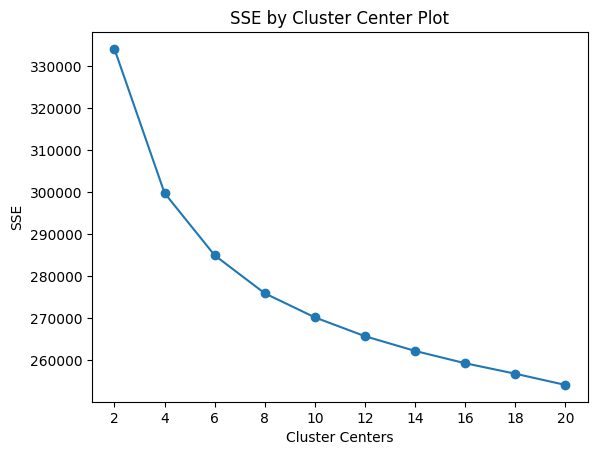

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Use the document embedding from labler.py to cluster the data to identify additional spam
## The ratios of before and after clustering are printed to compare the results. 

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        sse.append(kmeans.inertia_)
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

# Junk threshold is at 25 - will make dynamic in the future
jthreshold = 0.25
def ratio(data, label_column):
    return data[label_column].value_counts(normalize=True)

labeled_data['label'] = labeled_data['spam_label'].apply(lambda x: 1 if x == 'SPAM' else 0)
print(ratio(labeled_data, 'label'))
spam_kernel_text = labeled_data
relevant_texts = spam_kernel_text['text_clean']
# Convert the tensor to numpy array and then to list
spam_kernel_text['vector'] = relevant_texts.apply(lambda x: spam_detector.document_embedding(x).numpy().tolist())
# Convert list of lists to np array
X = np.vstack(spam_kernel_text['vector'].values)
spam_kernel_text.drop('vector', axis=1, inplace=True)
#Finding optimal clusters
find_optimal_clusters(X, 20)
#Set n_clusters to the optimal number you found from the plot
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(X)
spam_kernel_text['cluster'] = kmeans.labels_
cluster_junk_ratio = spam_kernel_text.groupby('cluster')['label'].mean()
print(cluster_junk_ratio)
cluster_junk_ratio = (cluster_junk_ratio - cluster_junk_ratio.min()) / (cluster_junk_ratio.max() - cluster_junk_ratio.min())
junk_clusters = cluster_junk_ratio[cluster_junk_ratio > jthreshold].index.tolist()
spam_kernel_text['label'] = spam_kernel_text['cluster'].isin(junk_clusters).astype(int)
print(ratio(spam_kernel_text, 'label'))

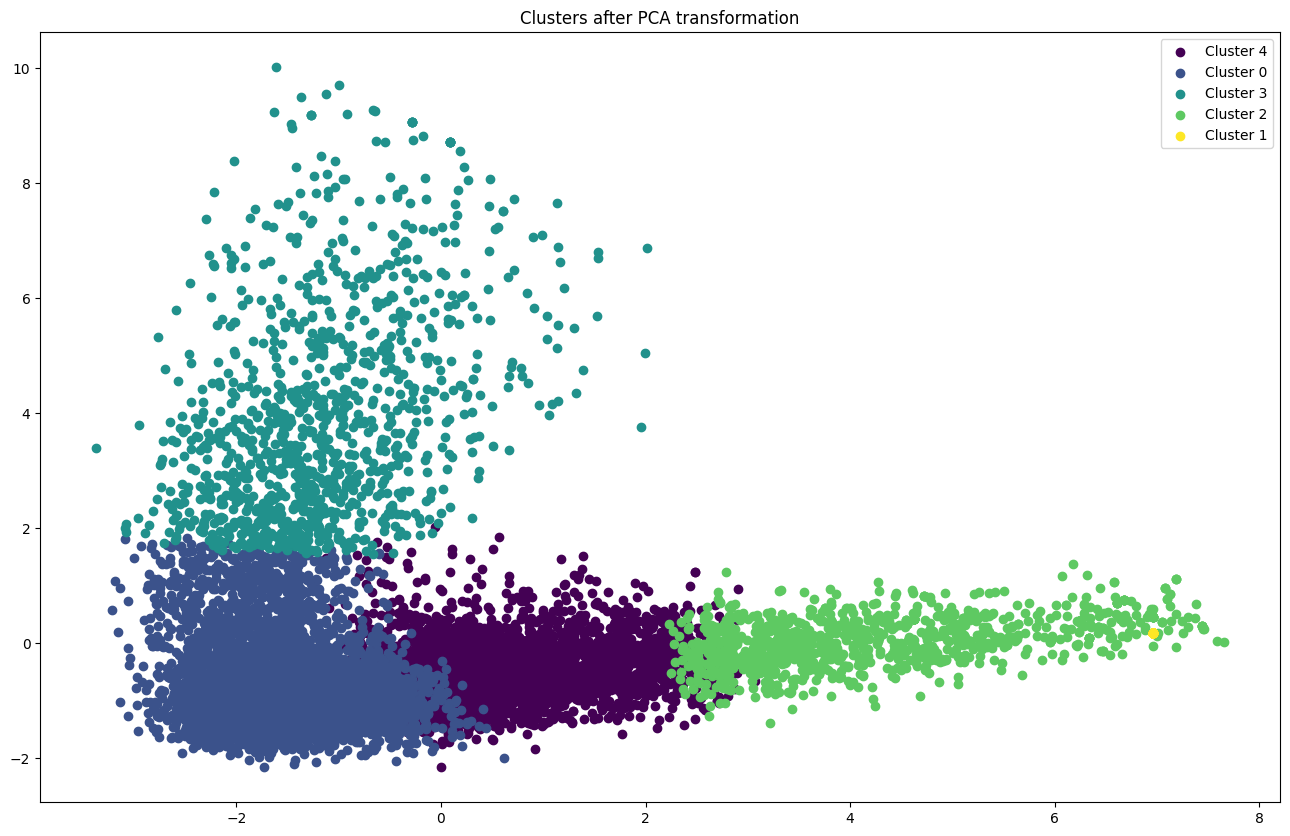

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the vectors to two dimensions using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Add the PCA result back to the dataframe
spam_kernel_text['pca-one'] = pca_result[:, 0]
spam_kernel_text['pca-two'] = pca_result[:, 1]

plt.figure(figsize=(16, 10))
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(spam_kernel_text['cluster'].unique()))]
for cluster, color in zip(spam_kernel_text['cluster'].unique(), colors):
    plt.scatter(spam_kernel_text[spam_kernel_text['cluster'] == cluster]['pca-one'], 
                spam_kernel_text[spam_kernel_text['cluster'] == cluster]['pca-two'], 
                color=color, 
                label=f"Cluster {cluster}")

plt.title('Clusters after PCA transformation')
plt.legend()
plt.show()


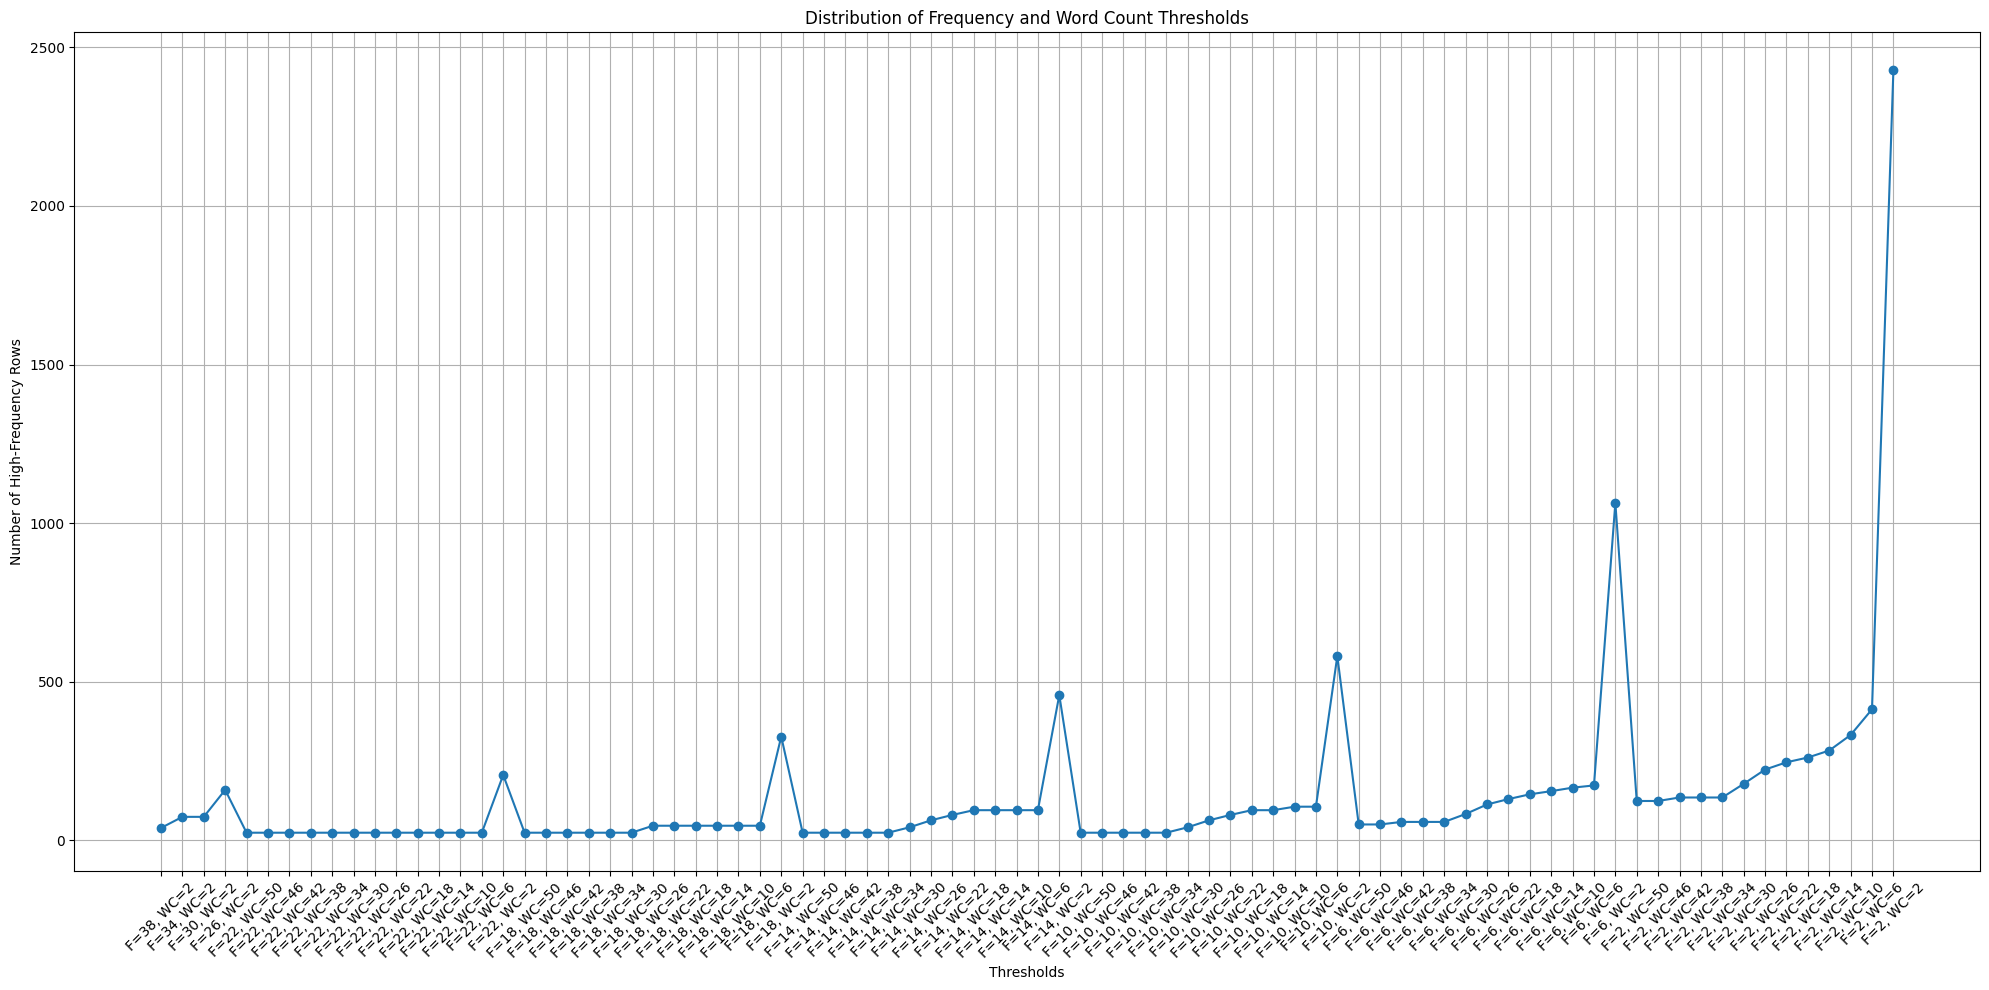

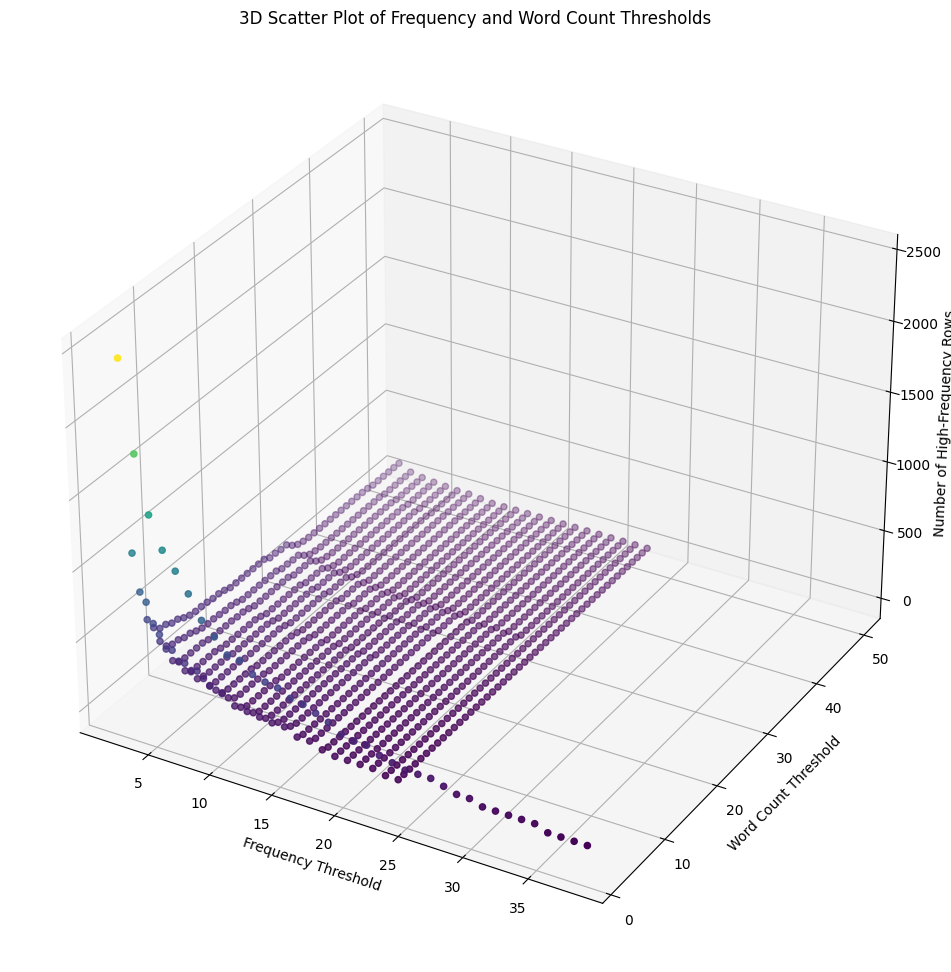

In [16]:
from srcs.freq_logging import load_and_combine_top, get_averages
from utils.fnPlots import FrequencyLoggerPlotter
combined_frequency_distributions = load_and_combine_top('/data_drive/processed/freq_logging/', num_min_threshold=None, num_max_threshold=None, wc_min_threshold=None, wc_max_threshold=None, top_percent=1)
# max_freq, max_step, step_size
FrequencyLoggerPlotter = FrequencyLoggerPlotter(combined_frequency_distributions, 'text_clean')
# max_freq, max_step, step_size
FrequencyLoggerPlotter.plot_threshold_distribution(50,1,4)
FrequencyLoggerPlotter.plot_threshold_3Dscatter_distribution(50,1,1)